# Regression Modeling

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

In [3]:
df= pd.read_csv("/content/drive/MyDrive/UberFarePrediction/cleaned_uber_data.csv")

#### 1. Train and Select Regression Model

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
!pip -q install xgboost

In [5]:
from xgboost import XGBRegressor

In [6]:
#define features(X) and target(y)
X= df.drop(columns=['fare_amount'])
y= df['fare_amount']

In [7]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
#scale features(for models sensitive to feature scaling like SVR)
scaler= StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled= scaler.transform(X_test)

In [9]:
#training different models
models= {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regression": DecisionTreeRegressor(random_state=42),
    "Random Forest Regression": RandomForestRegressor(random_state=42, n_estimators=100),
    "Support Vector Regression": SVR(),
    "XGBoost Regression": XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    )
}
results= {}

for name, model in models.items():
    if name == "Support Vector Regression":
        model.fit(X_train_scaled, y_train)
        y_pred_train= model.predict(X_train_scaled)
        y_pred_test= model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred_train= model.predict(X_train)
        y_pred_test= model.predict(X_test)

    #evaluation metrics
    #train metrics
    mae_train= mean_absolute_error(y_train, y_pred_train)
    rmse_train= np.sqrt(mean_squared_error(y_train, y_pred_train))
    r2_train= r2_score(y_train, y_pred_train)

    #test metrics
    mae_test= mean_absolute_error(y_test, y_pred_test)
    rmse_test= np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test= r2_score(y_test, y_pred_test)

    results[name]= {
        "Train_MAE": mae_train, "Test_MAE": mae_test,
        "Train_RMSE": rmse_train, "Test_RMSE": rmse_test,
        "Train_R2": r2_train, "Test_R2": r2_test
    }

In [10]:
#train vs test metrics side by side
train_test_results= {name: {"Train_MAE": vals["Train_MAE"], "Test_MAE": vals["Test_MAE"],
                             "Train_RMSE": vals["Train_RMSE"], "Test_RMSE": vals["Test_RMSE"],
                             "Train_R2": vals["Train_R2"], "Test_R2": vals["Test_R2"]}
                      for name, vals in results.items()}

train_test_df= pd.DataFrame(train_test_results).T
print("Train vs Test Metrics for Each Model:")
print(train_test_df)

Train vs Test Metrics for Each Model:
                              Train_MAE  Test_MAE    Train_RMSE  Test_RMSE  \
Linear Regression          2.441602e+00  2.422483  5.093858e+00   4.861943   
Decision Tree Regression   6.499607e-18  3.253440  1.981739e-16   6.419161   
Random Forest Regression   9.040030e-01  2.403065  1.755107e+00   4.578930   
Support Vector Regression  2.175378e+00  2.168704  4.731718e+00   4.682703   
XGBoost Regression         2.172829e+00  2.227631  4.155530e+00   4.492874   

                           Train_R2   Test_R2  
Linear Regression          0.720939  0.743401  
Decision Tree Regression   1.000000  0.552707  
Random Forest Regression   0.966871  0.772404  
Support Vector Regression  0.759207  0.761972  
XGBoost Regression         0.814280  0.780879  


Random Forest and XGBoost achieved the best overall performance, with balanced train and test scores. Decision Tree showed clear overfitting, while Linear Regression and SVR underperformed.

#### 2. Evaluate (and compare) models

In [11]:
#display results
test_results= {name: {"Test_MAE": vals["Test_MAE"],
                       "Test_RMSE": vals["Test_RMSE"],
                       "Test_R2": vals["Test_R2"]}
                for name, vals in results.items()}

results_df = pd.DataFrame(test_results).T
print("Comparison of Models (Test Metrics Only):")
print(results_df)


Comparison of Models (Test Metrics Only):
                           Test_MAE  Test_RMSE   Test_R2
Linear Regression          2.422483   4.861943  0.743401
Decision Tree Regression   3.253440   6.419161  0.552707
Random Forest Regression   2.403065   4.578930  0.772404
Support Vector Regression  2.168704   4.682703  0.761972
XGBoost Regression         2.227631   4.492874  0.780879


We can see there's a close competition between Random Forest and XGBoost Regression.

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

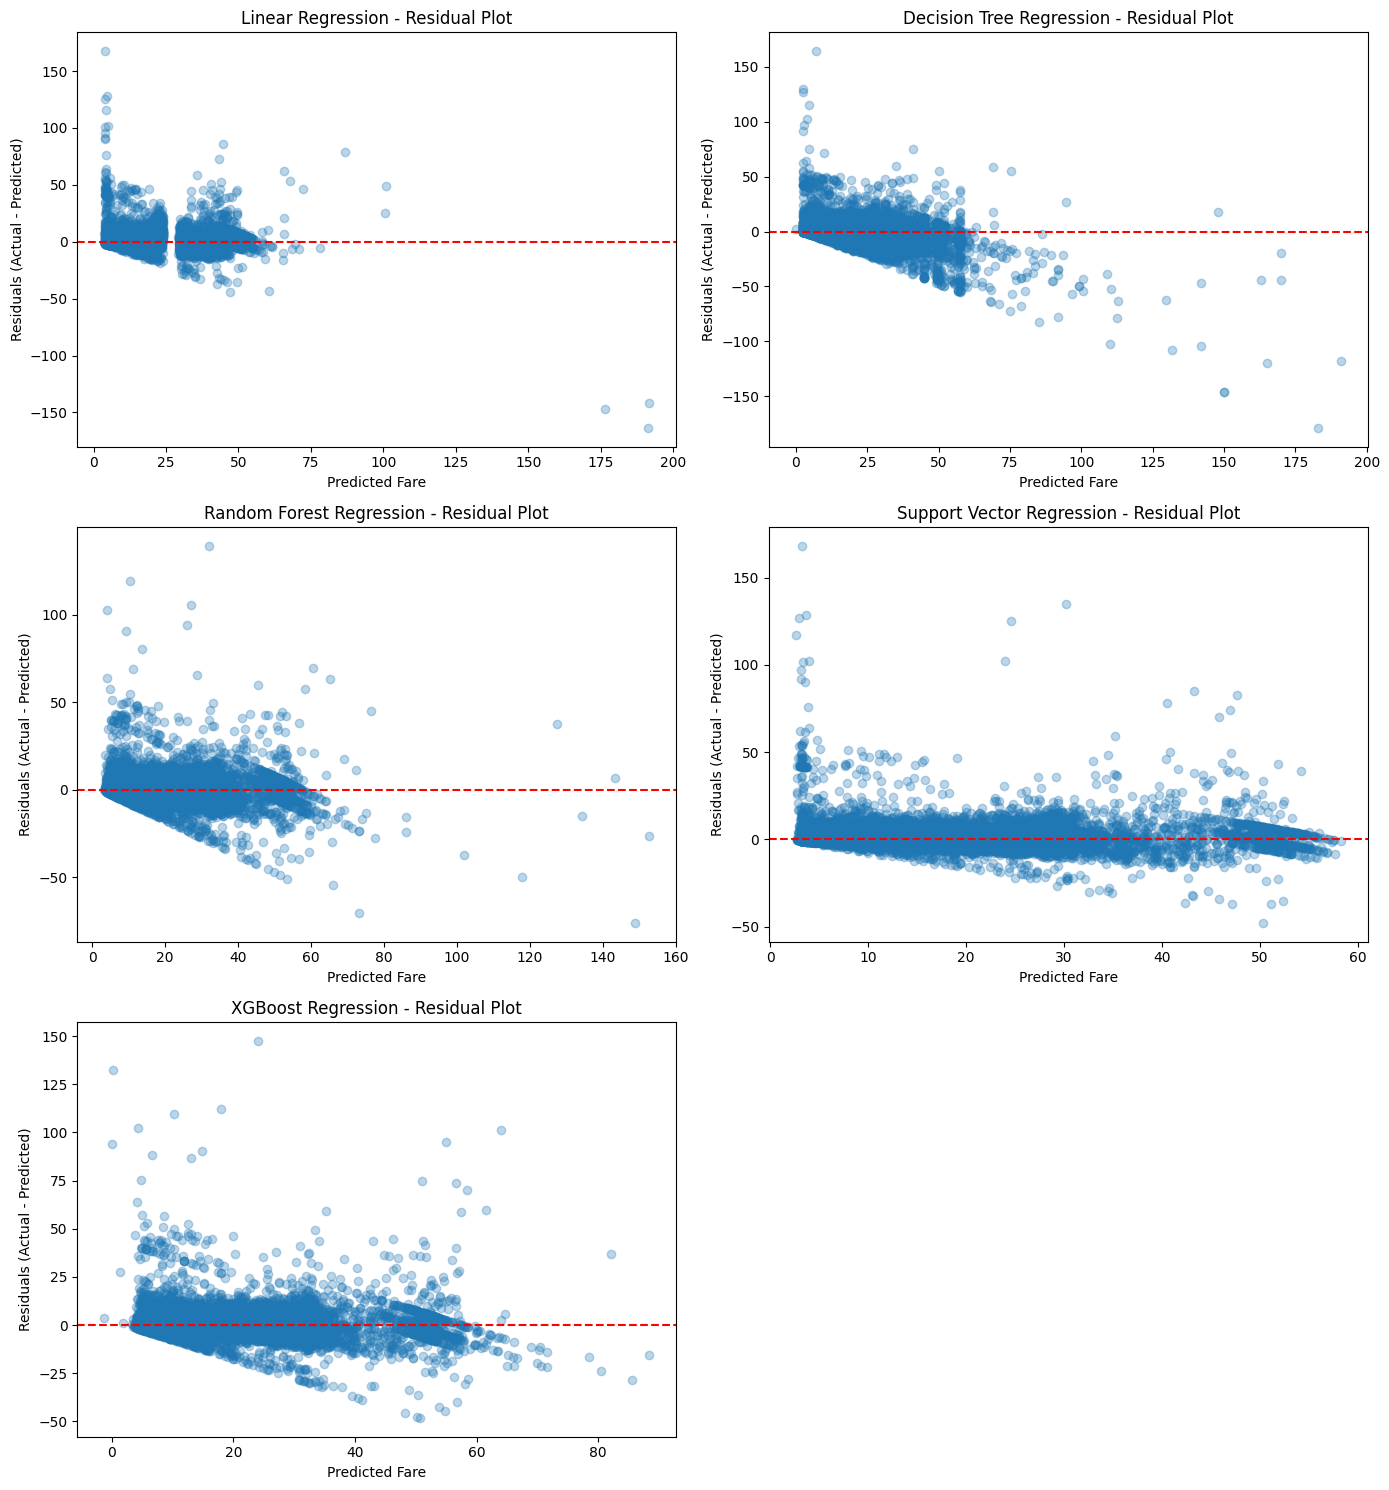

In [13]:
#individual models' residual plots
import math

n_models= len(models)
rows= math.ceil(n_models / 2)
fig, axes= plt.subplots(rows, 2, figsize=(14, 5*rows))

axes= axes.flatten()

for ax, (name, model) in zip(axes.flatten(), models.items()):
    if name == "Support Vector Regression":
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)

    residuals= y_test - y_pred
    ax.scatter(y_pred, residuals, alpha=0.3)
    ax.axhline(0, color='r', linestyle='--')
    ax.set_title(f"{name} - Residual Plot")
    ax.set_xlabel("Predicted Fare")
    ax.set_ylabel("Residuals (Actual - Predicted)")

#hide any unused subplot slots
for ax in axes[n_models:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

Linear Regression: Residuals show a funnel shape, meaning it struggles with higher fare values and underestimates them.

Decision Tree Regression: Residuals are more spread out and inconsistent, showing signs of overfitting and poor generalization.

Random Forest Regression: Residuals are more randomly scattered around zero, implying improved performance and reduced bias compared to single trees.

Support Vector Regression: Performs decently for lower fares but struggles with higher fares, where residuals spread out more.

XGBoost Regression: Residuals are well-distributed around zero with minimal outliers, indicating strong predictive accuracy and model robustness.

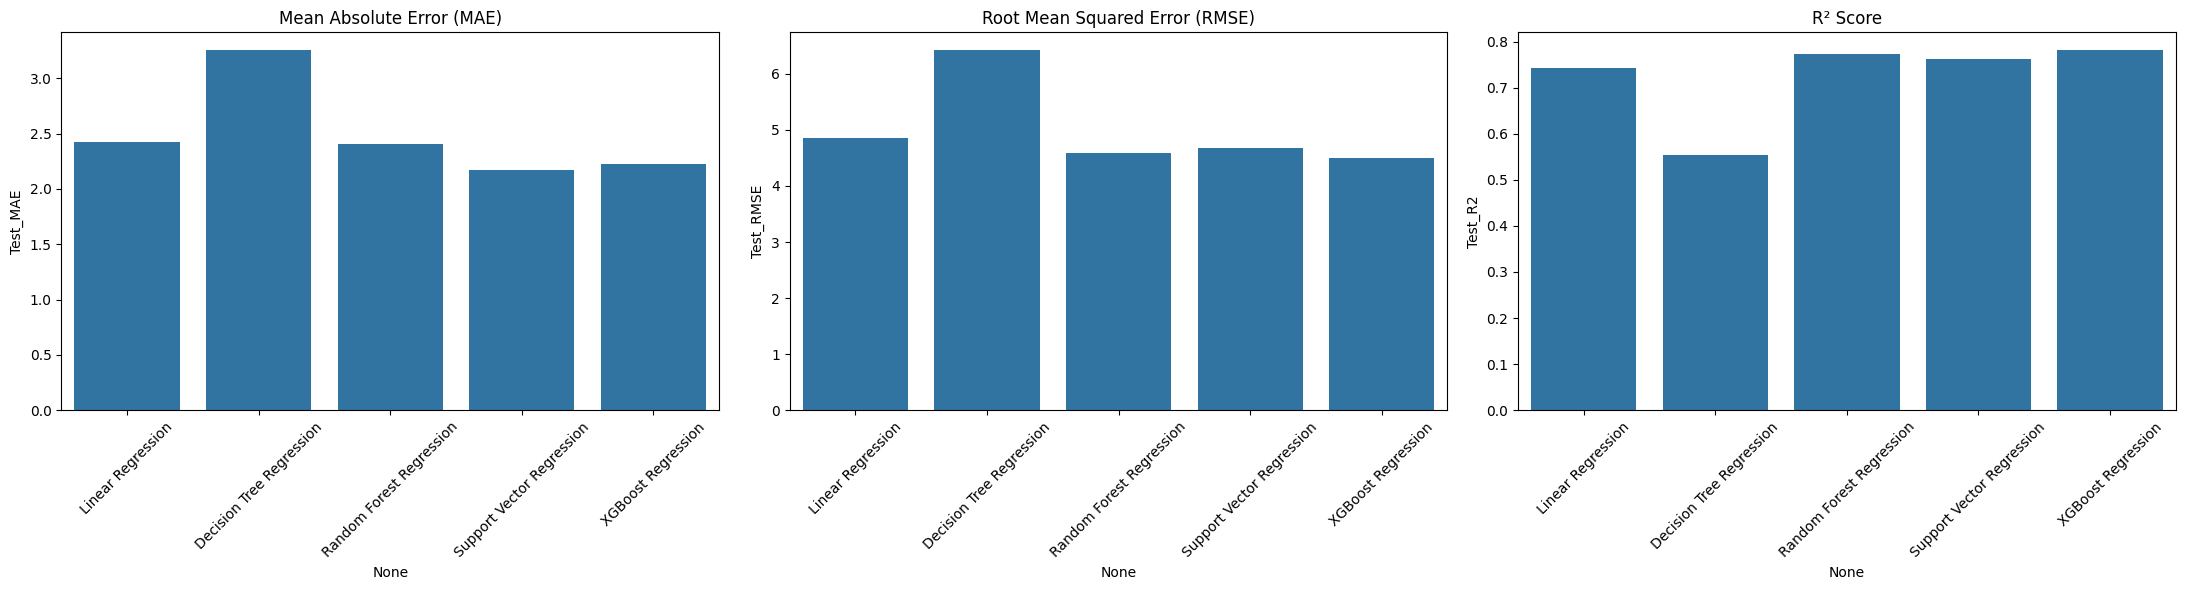

In [15]:
#visualization of performance
#plot metrics side by side
fig, axes= plt.subplots(1, 3, figsize=(22, 6))

sns.barplot(x=results_df.index, y="Test_MAE", data=results_df, ax=axes[0])
axes[0].set_title("Mean Absolute Error (MAE)")
axes[0].tick_params(axis='x', rotation=45)

sns.barplot(x=results_df.index, y="Test_RMSE", data=results_df, ax=axes[1])
axes[1].set_title("Root Mean Squared Error (RMSE)")
axes[1].tick_params(axis='x', rotation=45)

sns.barplot(x=results_df.index, y="Test_R2", data=results_df, ax=axes[2])
axes[2].set_title("R² Score")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

XGBoost Regression achieves the best performance overall, with the lowest MAE and RMSE and the highest R² score (~0.79), followed closely by Random Forest Regression. Hence, we'll fine-tune both just to compare again.

#### 3. Fine-tuning the Models

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
#tuning Rnadom Forest model using GridSearchCV
param_grid= {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2']
}

grid_search= GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Hyperparameters for Random Forest:", grid_search.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Hyperparameters for Random Forest: {'max_depth': 10, 'max_features': 'log2', 'n_estimators': 200}


Now that we got the best hyperparameters for Random Forest, we'll train it again to actually see the improvement.

In [18]:
tuned_rf= RandomForestRegressor(
    n_estimators=200,
    max_features='log2',
    max_depth=10,
    random_state=42
)

tuned_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features='log2', n_estimators=200,
                      random_state=42)

In [19]:
#evaluate the model again
y_pred_best= tuned_rf.predict(X_test)

print("Final Evaluation of the Random Forest Tuned Model:")
print("MAE:", mean_absolute_error(y_test, y_pred_best))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("R2:", r2_score(y_test, y_pred_best))

Final Evaluation of the Random Forest Tuned Model:
MAE: 2.247305775678242
RMSE: 4.348361810218639
R2: 0.794748166719482


After hyperparameter tuning using GridSearch, the Random Forest model showed improvement in performance (MAE and RMSE decreased certainly, and R² increased by about 0.2).

In [23]:
#tuning XGBoost model using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

xgb= XGBRegressor(random_state=42, n_jobs=-1)

param_dist= {
    "n_estimators": randint(300, 500),
    "max_depth": randint(4, 8),
    "learning_rate": uniform(0.05, 0.1),
    "subsample": uniform(0.7, 0.3),
    "colsample_bytree": uniform(0.7, 0.3),
    "reg_lambda": uniform(0.5, 1.5),
}

# xgb_rand= RandomizedSearchCV(
#     xgb, param_distributions=param_dist,
#     n_iter=25, cv=3, scoring="neg_mean_squared_error",
#     verbose=1, n_jobs=-1, random_state=42
# )

xgb_rand= RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=100,
    cv=3,
    scoring="neg_mean_squared_error",
    verbose=2,
    n_jobs=-1,
    random_state=42
)

xgb_rand.fit(X_train, y_train)
print("Best hyperparamters for XGBoost:", xgb_rand.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best hyperparamters for XGBoost: {'colsample_bytree': np.float64(0.7043180465889267), 'learning_rate': np.float64(0.061607264050691626), 'max_depth': 4, 'n_estimators': 346, 'reg_lambda': np.float64(0.5610932034784553), 'subsample': np.float64(0.9566381752033022)}


In [24]:
xgb_best= xgb_rand.best_estimator_
xgb_best.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=np.float64(0.7043180465889267), device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None,
             learning_rate=np.float64(0.061607264050691626), max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=346, n_jobs=-1,
             num_parallel_tree=None, ...)

In [34]:
y_pred_xgb_tuned= xgb_best.predict(X_test)

#re-evaluation
print("Final Evaluation of Tuned XGBoost:")
print("MAE:", mean_absolute_error(y_test, y_pred_xgb_tuned))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb_tuned)))
print("R2:", r2_score(y_test, y_pred_xgb_tuned))

Final Evaluation of Tuned XGBoost:
MAE: 2.2176252164207377
RMSE: 4.407899855351868
R2: 0.7890890454399949


After thorough hyperparameter tuning, Random Forest achieved an R² score of 0.795 and XGBoost achieved 0.789 (~0.79), but the MAE was less for XGBoost. Given the very small performance difference and the advantages of XGBoost in regularization, scalability, and industry use, we select the tuned XGBoost model as the final model for further use.

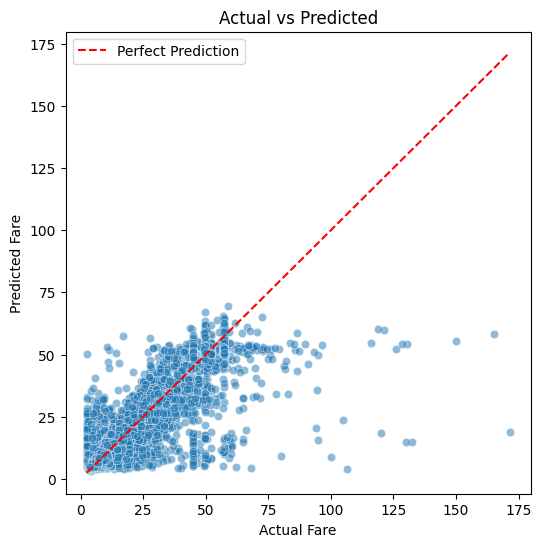

In [35]:
#Actual vs Predicted Visualization of XGBoost Model
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_xgb_tuned, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color="red", linestyle="--", label="Perfect Prediction")
plt.title("Actual vs Predicted")
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.legend()
plt.show()

The scatter plot shows that the model demonstrates strong predictive performance overall, capturing the general fare patterns well. While there is some variability at higher fare ranges, the tuned XGBoost provides a reliable balance between accuracy and generalization, making it well-suited for this dataset.

In [36]:
#saving the model
import joblib
joblib.dump(xgb_best, "/content/drive/MyDrive/UberFarePrediction/tuned_xgboost_model.pkl")
print("Model saved.")

Model saved.
